### Regression - Forecasting and Predicting

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import quandl, math
import numpy as np
import datetime

# preprocessing can scale data (data scaled to (0,1) for example)
# model_selection shuffles data (remove bias) and separate data (formerly: cross_validation)
# svm (support vector machines) for regression
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression

In [91]:
df = quandl.get('WIKI/GOOGL')

In [92]:
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close', 'Adj. Volume']]
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


In [93]:
df['HL_pct'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100
df['Pct_change'] = (df['Adj. Open'] - df['Adj. Close']) / df['Adj. Close'] * 100

In [94]:
df = df[['Adj. Close', 'HL_pct', 'Pct_change', 'Adj. Volume']]
df.head()# dataframe is now different

,Adj. Close,HL_pct,Pct_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,8.441017,-0.323915,44659000.0
2004-08-20,54.322689,8.537313,-6.739913,22834300.0
2004-08-23,54.869377,4.062357,1.243144,18256100.0
2004-08-24,52.597363,7.753210,6.074187,15247300.0
2004-08-25,53.164113,3.966115,-1.169811,9188600.0


In [95]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True) # inplace=True changes df permanently (False creates a copy)

In [96]:
forecast_out = math.ceil(0.01*(len(df))) # math.ceil returns the smallest integer greater than or equal to 34.2 which is 35 
forecast_out

35

In [97]:
# the adj close price 35 days ago will be that day's predicted price in df['label']
# shift: https://stackoverflow.com/questions/20095673/python-shift-column-in-pandas-dataframe-up-by-one
df['Label'] = df[forecast_col].shift(-forecast_out)
#df.dropna(inplace=True)

### Features (X) and Labels (y)

In [98]:
# X is the price
X = np.array(df.drop(['Label'],1))


# scale X
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['Label'])
len(X)

3389

In [99]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

### Classifiers

In [100]:
import pickle

In [101]:
# First, try using a linear regression
# classifier (NB: n_jobs can speed up process)
clf =LinearRegression()
clf.fit(X_train, y_train) # fit (or train) a classifier
#with open('clf.pickle', 'wb') as f:
#    pickle.dump(clf, f, pickle.HIGHEST_PROTOCOL) # dumping clf into f

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [102]:
#pickle_in = open('clf.pickle', 'rb')
#clf = pickle.load(f)

with open('clf.pickle', 'rb') as f:
    clf = pickle.load(f)

In [103]:
accuracy = clf.score(X_test, y_test) # score (or test), gives us the square error

In [104]:
# want to predict on last 35 days
forecast_set = clf.predict(X_lately)

In [105]:
# Basically done at this point
print(forecast_set, accuracy, forecast_out)

[1101.70844445 1073.86575214 1019.92332496 1059.50404633 1074.57210519
 1075.24383034 1093.01981286 1111.68909204 1116.71498396 1124.26781385
 1134.11759118 1130.95626837 1149.71699798 1166.00441456 1137.47519199
 1123.99205624 1088.69835227 1103.4871527  1115.22999145 1122.91329013
 1136.08427411 1151.56938433 1182.239743   1187.74601393 1158.62262496
 1170.70220633 1171.6866209  1154.69797341 1119.3152066  1116.06986457
 1114.72922664 1071.09210043 1043.72176531 1071.08637196 1020.39381857] 0.9794117116683995 35


### Visualising the Information

In [106]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [107]:
# add the forecast column to our dataframe, full of NaN
df['Forecast'] = np.nan

In [108]:
# grabs last day in the DF, assigns each new forecast to a new day
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
# hardcoding to produce graph
one_day = 86400
next_unix = last_unix + one_day
df.tail()

,Adj. Close,HL_pct,Pct_change,Adj. Volume,Label,Forecast
Date,,,,,,
2018-01-30,1177.37,1.142604,0.029727,1792602.0,1094.00,NaN
2018-01-31,1182.22,1.213207,0.134493,1643877.0,1053.15,NaN
2018-02-01,1181.59,1.547000,-0.473938,2774967.0,1026.55,NaN
2018-02-02,1119.20,1.811604,0.734453,5798880.0,1054.09,NaN
2018-02-05,1068.76,5.512236,2.980089,3742469.0,1006.94,NaN


In [109]:
# iterate through forecast_set, take each forecast/day, set values in DF

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
df.tail()

,Adj. Close,HL_pct,Pct_change,Adj. Volume,Label,Forecast
Date,,,,,,
2018-03-08 01:00:00,NaN,NaN,NaN,NaN,NaN,1114.729227
2018-03-09 01:00:00,NaN,NaN,NaN,NaN,NaN,1071.092100
2018-03-10 01:00:00,NaN,NaN,NaN,NaN,NaN,1043.721765
2018-03-11 01:00:00,NaN,NaN,NaN,NaN,NaN,1071.086372
2018-03-12 01:00:00,NaN,NaN,NaN,NaN,NaN,1020.393819


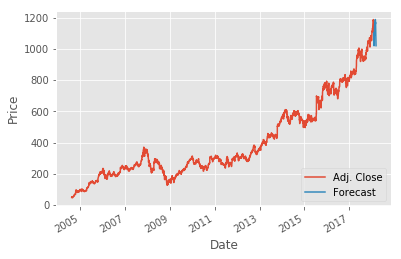

In [110]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()